In [1]:
# Cell: HPO quality check for base_full_point_20251117-0922
#
# Notes:
# - Optuna 'value' is still log-space (val_mae on log1p(price)) for the STUDY OBJECTIVE.
# - This cell, however, analyzes HPO quality **in target space only**:
#     * Uses mae_orig / rmse_orig from per-trial metrics.csv (validation split, best epoch).
#     * Optionally falls back to eval_metrics_val.json/test.json if present.
#   If no per-trial original-space metrics exist, this cell raises an error
#   rather than reporting anything in log space.

import json
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 0) Point to your HPO job root
# ---------------------------------------------------------------------

JOB_ROOT = Path(r"Z:\uncertainty_quantification\outputs\optuna\prune2_new_ds_base_point_20251120-1706")
# JOB_ROOT = Path(r"Z:\uncertainty_quantification\outputs\optuna\base_full_point_adjusted_2_20251118-2107")

MANIFEST_PATH = JOB_ROOT / "manifest" / "run_manifest.json"

print("MANIFEST    :", MANIFEST_PATH)

if not MANIFEST_PATH.exists():
    raise FileNotFoundError(f"Manifest not found: {MANIFEST_PATH}")

with MANIFEST_PATH.open("r") as f:
    manifest = json.load(f)

study_cfg = manifest["study"]
study_name = study_cfg["name"]

# ---------------------------------------------------------------------
# Override storage URL to point to the local SQLite DB on this machine
# ---------------------------------------------------------------------
DB_PATH = Path(r"Z:\uncertainty_quantification\optuna_studies\hpo.db")
if not DB_PATH.exists():
    raise FileNotFoundError(f"Optuna DB not found at {DB_PATH}")

# On Windows, sqlite:///Z:/... is the correct form
storage_url = f"sqlite:///{DB_PATH.as_posix()}"

print(f"[info] Study name   : {study_name}")
print(f"[info] Storage URL  : {storage_url}")
print(f"[info] Job root     : {JOB_ROOT}")

TRIALS_ROOT = JOB_ROOT / "trials"

# ---------------------------------------------------------------------
# 1) Load Optuna study and build a DataFrame of trials
# ---------------------------------------------------------------------
study = optuna.load_study(study_name=study_name, storage=storage_url)

# Only keep completed trials
completed = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
if not completed:
    raise RuntimeError("No completed trials in this study.")

records = []
for t in completed:
    rec = {
        "number": t.number,
        "value": t.value,  # Optuna objective (log-space), kept only for reference, NOT used in outputs
        "state": str(t.state),
    }

    # ---------------------------
    # Derive mae_orig / rmse_orig in TARGET SPACE for this trial
    # ---------------------------
    trial_dir = TRIALS_ROOT / f"trial_{t.number:05d}"
    mae_orig = None
    rmse_orig = None

    # 1) Primary path: metrics.csv at best_epoch (from run_meta.json)
    metrics_path = trial_dir / "metrics.csv"
    run_meta_path = trial_dir / "run_meta.json"
    best_epoch_from_meta = None

    if run_meta_path.is_file():
        try:
            with run_meta_path.open("r") as f:
                run_meta = json.load(f)
            best_epoch_from_meta = int(run_meta.get("best_epoch", -1))
        except Exception:
            best_epoch_from_meta = None

    if metrics_path.is_file():
        try:
            mdf = pd.read_csv(metrics_path)

            # We care about validation rows only
            if "split" in mdf.columns:
                mval = mdf[mdf["split"] == "val"].copy()
            else:
                mval = pd.DataFrame()

            if not mval.empty:
                # Ensure numeric epoch
                if "epoch" in mval.columns:
                    mval["epoch"] = pd.to_numeric(mval["epoch"], errors="coerce")
                else:
                    mval["epoch"] = np.arange(len(mval))

                row = None

                # Prefer the best_epoch from run_meta.json if present and found
                if best_epoch_from_meta is not None and best_epoch_from_meta >= 0:
                    row = mval[mval["epoch"] == best_epoch_from_meta]
                    if row.empty:
                        row = None

                # If no row from best_epoch, fall back to min objective on val split
                if row is None:
                    if "objective" in mval.columns:
                        obj_col = pd.to_numeric(mval["objective"], errors="coerce")
                        if obj_col.notna().any():
                            best_idx = obj_col.idxmin()
                            row = mval.loc[[best_idx]]
                        else:
                            row = None
                    else:
                        row = None

                # Final fallback: last val row if everything else fails
                if row is None:
                    row = mval.iloc[[-1]]

                # Extract mae_orig / rmse_orig from the chosen row
                if "mae_orig" in row.columns:
                    mae_val = pd.to_numeric(row["mae_orig"], errors="coerce").iloc[0]
                    if np.isfinite(mae_val):
                        mae_orig = float(mae_val)
                if "rmse_orig" in row.columns:
                    rmse_val = pd.to_numeric(row["rmse_orig"], errors="coerce").iloc[0]
                    if np.isfinite(rmse_val):
                        rmse_orig = float(rmse_val)

        except Exception:
            # If something goes wrong parsing metrics.csv, fall back to eval_* files below.
            pass

    # 2) Fallback: eval_metrics_val.json / eval_metrics_test.json inside trial_dir
    if mae_orig is None:
        for cand_name in ["eval_metrics_val.json", "eval_metrics_test.json"]:
            cand_path = trial_dir / cand_name
            if cand_path.is_file():
                try:
                    with cand_path.open("r") as f:
                        eval_payload = json.load(f)
                    mae_val = eval_payload.get("mae_orig", None)
                    rmse_val = eval_payload.get("rmse_orig", None)
                    if mae_val is not None and np.isfinite(mae_val):
                        mae_orig = float(mae_val)
                    if rmse_val is not None and np.isfinite(rmse_val):
                        rmse_orig = float(rmse_val)
                except Exception:
                    pass  # ignore malformed files

    rec["mae_orig"] = mae_orig
    rec["rmse_orig"] = rmse_orig

    # Flatten important params for quick inspection
    for key in [
        "training.lr",
        "training.weight_decay",
        "training.grad_clip",
        "training.epochs",
        "data.batch_size",
        "model.hidden_dims",
        "model.dropout",
        "model.activation",
        "model.batchnorm",
        "training.point_loss",
    ]:
        rec[key] = t.params.get(key, None)

    records.append(rec)

df = pd.DataFrame.from_records(records).sort_values("number").reset_index(drop=True)

# ---------------------------------------------------------------------
# 1) Basic summary (TARGET SPACE: MAE on original target)
# ---------------------------------------------------------------------
n_trials_total = len(df)
df_mae = df[df["mae_orig"].notna()].copy()

if df_mae.empty:
    raise RuntimeError(
        "No mae_orig metrics found for any completed trial. "
        "Make sure train_regression.py writes metrics.csv with mae_orig/ rmse_orig "
        "and that those files exist in each trial directory."
    )

n_trials_mae = len(df_mae)
best_row = df_mae.loc[df_mae["mae_orig"].idxmin()]

print("\n=== 1) Basic summary (target space: MAE on original target) ===")
print(f"Completed trials (Optuna)        : {n_trials_total}")
print(f"Trials with mae_orig available   : {n_trials_mae}")

print(f"\nBest trial by mae_orig           : #{int(best_row['number'])}")
print(f"  mae_orig (validation)          : {best_row['mae_orig']:.3f}")
if pd.notna(best_row.get("rmse_orig", np.nan)):
    print(f"  rmse_orig (validation)         : {best_row['rmse_orig']:.3f}")

print("\nDistribution of mae_orig over trials with metrics:")
print(f"  Median mae_orig                : {df_mae['mae_orig'].median():.3f}")
print(f"  25th percentile mae_orig       : {df_mae['mae_orig'].quantile(0.25):.3f}")
print(f"  75th percentile mae_orig       : {df_mae['mae_orig'].quantile(0.75):.3f}")

improvement_vs_median_mae = (df_mae["mae_orig"].median() - best_row["mae_orig"]) / df_mae["mae_orig"].median()
print(f"\nRelative improvement vs median (mae_orig): {100 * improvement_vs_median_mae:.2f}%")

# ---------------------------------------------------------------------
# 2) Optimization history – mae_orig (TARGET SPACE)
# ---------------------------------------------------------------------
mae_values = df_mae["mae_orig"].to_numpy()
trial_numbers_mae = df_mae["number"].to_numpy()
best_so_far_mae = np.minimum.accumulate(mae_values)

plt.figure(figsize=(8, 5))
plt.plot(trial_numbers_mae, mae_values, "o", alpha=0.4, label="val MAE (target space) per trial")
plt.plot(trial_numbers_mae, best_so_far_mae, "-", linewidth=2, label="best so far (MAE)")
plt.xlabel("Trial number")
plt.ylabel("Validation MAE (target space)")
plt.title("Optimization history (target space: MAE on original target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Last-K analysis in target space
K = min(20, len(df_mae))
last_k_mae = mae_values[-K:]
best_overall_mae = mae_values.min()
best_last_k_mae = last_k_mae.min()
improv_last_k_mae = best_last_k_mae - best_overall_mae
n_updates_last_k_mae = np.sum(best_so_far_mae[-K:] == best_overall_mae)

print("\n=== 2) Last-20 behaviour (target-space MAE) ===")
print(f"Best overall mae_orig            : {best_overall_mae:.3f}")
print(f"Best among last {K} trials       : {best_last_k_mae:.3f}")
print(f"Gap (best_last_k - best)         : {improv_last_k_mae:.3f}")
print(f"Number of best-value updates in last {K} trials: {n_updates_last_k_mae}")

# ---------------------------------------------------------------------
# 3) Top-k trials table – do good configs cluster? (TARGET SPACE)
# ---------------------------------------------------------------------
TOP_K = min(10, len(df_mae))
df_top = df_mae.nsmallest(TOP_K, "mae_orig").copy()

print(f"\n=== 3) Top {TOP_K} trials (sorted by validation mae_orig) ===")
cols_to_show = [
    "number",
    "mae_orig",
    "rmse_orig",
    "training.lr",
    "training.weight_decay",
    "data.batch_size",
    "model.hidden_dims",
    "model.dropout",
    "model.activation",
    "training.point_loss",
]
display(df_top[cols_to_show])


MANIFEST    : Z:\uncertainty_quantification\outputs\optuna\prune2_new_ds_base_point_20251120-1706\manifest\run_manifest.json


FileNotFoundError: Manifest not found: Z:\uncertainty_quantification\outputs\optuna\prune2_new_ds_base_point_20251120-1706\manifest\run_manifest.json

MANIFEST    : Z:\uncertainty_quantification\outputs\optuna\base_point_20251121-1759\manifest\run_manifest.json
[info] Study name   : base_point
[info] Storage URL  : sqlite:///Z:/uncertainty_quantification/optuna_studies/hpo.db
[info] Job root     : Z:\uncertainty_quantification\outputs\optuna\base_point_20251121-1759


c:\Users\canel\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 128] which is of type list.
  warnings.warn(message)
c:\Users\canel\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256, 128] which is of type list.
  warnings.warn(message)
c:\Users\canel\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512, 256] which is of type list.
  warnings.warn(message)
c:\Users\canel\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and 


=== 1) Basic summary (target space: MAE on original target) ===
Completed trials (Optuna)        : 55
Trials with mae_orig available   : 55

Best trial by mae_orig           : #38
  mae_orig (validation)          : 2791.469
  rmse_orig (validation)         : 5941.089

Distribution of mae_orig over trials with metrics:
  Median mae_orig                : 2861.860
  25th percentile mae_orig       : 2833.844
  75th percentile mae_orig       : 2932.670

Relative improvement vs median (mae_orig): 2.46%


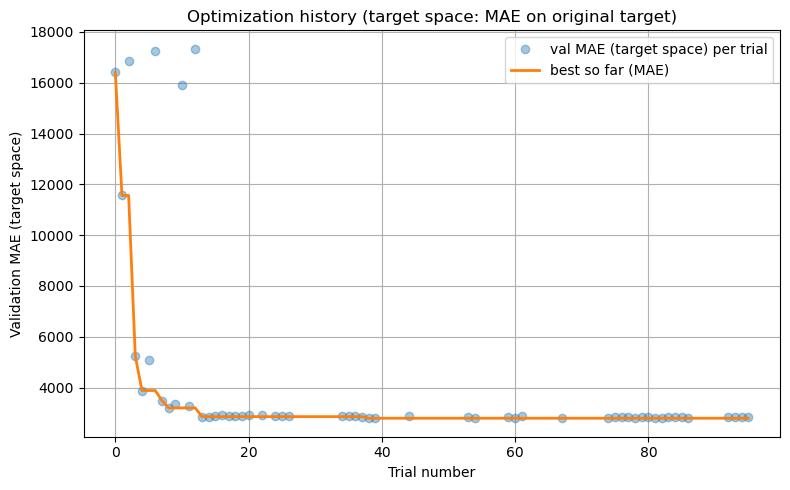


=== 2) Last-20 behaviour (target-space MAE) ===
Best overall mae_orig            : 2791.469
Best among last 20 trials       : 2808.550
Gap (best_last_k - best)         : 17.081
Number of best-value updates in last 20 trials: 20

=== 3) Top 10 trials (sorted by validation mae_orig) ===


,number,mae_orig,rmse_orig,training.lr,training.weight_decay,data.batch_size,model.hidden_dims,model.dropout,model.activation,training.point_loss
29,38,2791.468994,5941.088867,0.002343,0.000001,512,"[768, 384, 192]",0.30,gelu,huber
30,39,2799.274170,6065.505371,0.002486,0.000028,512,"[768, 384, 192]",0.25,gelu,huber
33,54,2804.334717,5934.789062,0.002774,0.000002,512,"[768, 384, 192]",0.25,gelu,huber
37,67,2808.550293,5902.306152,0.002672,0.000003,512,"[768, 384, 192]",0.25,gelu,huber
46,82,2810.453613,5958.856445,0.002584,0.000003,512,"[768, 384, 192]",0.20,gelu,huber
50,86,2816.212891,5915.632812,0.001711,0.000007,512,"[768, 384, 192]",0.15,gelu,huber
42,78,2816.763184,5936.412109,0.002211,0.000003,512,"[768, 384, 192]",0.20,gelu,huber
38,74,2816.953857,5923.378906,0.002999,0.000003,512,"[768, 384, 192]",0.25,gelu,huber
35,60,2816.965820,5911.668945,0.002048,0.000002,512,"[768, 384, 192]",0.25,gelu,huber
45,81,2820.044434,5989.847168,0.001669,0.000003,512,"[768, 384, 192]",0.20,gelu,huber


In [ ]:
# Cell: HPO quality check for base_full_point_20251117-0922
#
# Notes:
# - Optuna 'value' is still log-space (val_mae on log1p(price)) for the STUDY OBJECTIVE.
# - This cell, however, analyzes HPO quality **in target space only**:
#     * Uses mae_orig / rmse_orig from per-trial metrics.csv (validation split, best epoch).
#     * Optionally falls back to eval_metrics_val.json/test.json if present.
#   If no per-trial original-space metrics exist, this cell raises an error
#   rather than reporting anything in log space.

import json
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 0) Point to your HPO job root
# -------------------------`--------------------------------------------

JOB_ROOT = Path(r"Z:\uncertainty_quantification\outputs\optuna\base_point_20251121-1759")


MANIFEST_PATH = JOB_ROOT / "manifest" / "run_manifest.json"

print("MANIFEST    :", MANIFEST_PATH)

if not MANIFEST_PATH.exists():
    raise FileNotFoundError(f"Manifest not found: {MANIFEST_PATH}")

with MANIFEST_PATH.open("r") as f:
    manifest = json.load(f)

study_cfg = manifest["study"]
study_name = study_cfg["name"]

# ---------------------------------------------------------------------
# Override storage URL to point to the local SQLite DB on this machine
# ---------------------------------------------------------------------
DB_PATH = Path(r"Z:\uncertainty_quantification\optuna_studies\hpo.db")
if not DB_PATH.exists():
    raise FileNotFoundError(f"Optuna DB not found at {DB_PATH}")

# On Windows, sqlite:///Z:/... is the correct form
storage_url = f"sqlite:///{DB_PATH.as_posix()}"

print(f"[info] Study name   : {study_name}")
print(f"[info] Storage URL  : {storage_url}")
print(f"[info] Job root     : {JOB_ROOT}")

TRIALS_ROOT = JOB_ROOT / "trials"

# ---------------------------------------------------------------------
# 1) Load Optuna study and build a DataFrame of trials
# ---------------------------------------------------------------------
study = optuna.load_study(study_name=study_name, storage=storage_url)

# Only keep completed trials
completed = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
if not completed:
    raise RuntimeError("No completed trials in this study.")

records = []
for t in completed:
    rec = {
        "number": t.number,
        "value": t.value,  # Optuna objective (log-space), kept only for reference, NOT used in outputs
        "state": str(t.state),
    }

    # ---------------------------
    # Derive mae_orig / rmse_orig in TARGET SPACE for this trial
    # ---------------------------
    trial_dir = TRIALS_ROOT / f"trial_{t.number:05d}"
    mae_orig = None
    rmse_orig = None

    # 1) Primary path: metrics.csv at best_epoch (from run_meta.json)
    metrics_path = trial_dir / "metrics.csv"
    run_meta_path = trial_dir / "run_meta.json"
    best_epoch_from_meta = None

    if run_meta_path.is_file():
        try:
            with run_meta_path.open("r") as f:
                run_meta = json.load(f)
            best_epoch_from_meta = int(run_meta.get("best_epoch", -1))
        except Exception:
            best_epoch_from_meta = None

    if metrics_path.is_file():
        try:
            mdf = pd.read_csv(metrics_path)

            # We care about validation rows only
            if "split" in mdf.columns:
                mval = mdf[mdf["split"] == "val"].copy()
            else:
                mval = pd.DataFrame()

            if not mval.empty:
                # Ensure numeric epoch
                if "epoch" in mval.columns:
                    mval["epoch"] = pd.to_numeric(mval["epoch"], errors="coerce")
                else:
                    mval["epoch"] = np.arange(len(mval))

                row = None

                # Prefer the best_epoch from run_meta.json if present and found
                if best_epoch_from_meta is not None and best_epoch_from_meta >= 0:
                    row = mval[mval["epoch"] == best_epoch_from_meta]
                    if row.empty:
                        row = None

                # If no row from best_epoch, fall back to min objective on val split
                if row is None:
                    if "objective" in mval.columns:
                        obj_col = pd.to_numeric(mval["objective"], errors="coerce")
                        if obj_col.notna().any():
                            best_idx = obj_col.idxmin()
                            row = mval.loc[[best_idx]]
                        else:
                            row = None
                    else:
                        row = None

                # Final fallback: last val row if everything else fails
                if row is None:
                    row = mval.iloc[[-1]]

                # Extract mae_orig / rmse_orig from the chosen row
                if "mae_orig" in row.columns:
                    mae_val = pd.to_numeric(row["mae_orig"], errors="coerce").iloc[0]
                    if np.isfinite(mae_val):
                        mae_orig = float(mae_val)
                if "rmse_orig" in row.columns:
                    rmse_val = pd.to_numeric(row["rmse_orig"], errors="coerce").iloc[0]
                    if np.isfinite(rmse_val):
                        rmse_orig = float(rmse_val)

        except Exception:
            # If something goes wrong parsing metrics.csv, fall back to eval_* files below.
            pass

    # 2) Fallback: eval_metrics_val.json / eval_metrics_test.json inside trial_dir
    if mae_orig is None:
        for cand_name in ["eval_metrics_val.json", "eval_metrics_test.json"]:
            cand_path = trial_dir / cand_name
            if cand_path.is_file():
                try:
                    with cand_path.open("r") as f:
                        eval_payload = json.load(f)
                    mae_val = eval_payload.get("mae_orig", None)
                    rmse_val = eval_payload.get("rmse_orig", None)
                    if mae_val is not None and np.isfinite(mae_val):
                        mae_orig = float(mae_val)
                    if rmse_val is not None and np.isfinite(rmse_val):
                        rmse_orig = float(rmse_val)
                except Exception:
                    pass  # ignore malformed files

    rec["mae_orig"] = mae_orig
    rec["rmse_orig"] = rmse_orig

    # Flatten important params for quick inspection
    for key in [
        "training.lr",
        "training.weight_decay",
        "training.grad_clip",
        "training.epochs",
        "data.batch_size",
        "model.hidden_dims",
        "model.dropout",
        "model.activation",
        "model.batchnorm",
        "training.point_loss",
    ]:
        rec[key] = t.params.get(key, None)

    records.append(rec)

df = pd.DataFrame.from_records(records).sort_values("number").reset_index(drop=True)

# ---------------------------------------------------------------------
# 1) Basic summary (TARGET SPACE: MAE on original target)
# ---------------------------------------------------------------------
n_trials_total = len(df)
df_mae = df[df["mae_orig"].notna()].copy()

if df_mae.empty:
    raise RuntimeError(
        "No mae_orig metrics found for any completed trial. "
        "Make sure train_regression.py writes metrics.csv with mae_orig/ rmse_orig "
        "and that those files exist in each trial directory."
    )

n_trials_mae = len(df_mae)
best_row = df_mae.loc[df_mae["mae_orig"].idxmin()]

print("\n=== 1) Basic summary (target space: MAE on original target) ===")
print(f"Completed trials (Optuna)        : {n_trials_total}")
print(f"Trials with mae_orig available   : {n_trials_mae}")

print(f"\nBest trial by mae_orig           : #{int(best_row['number'])}")
print(f"  mae_orig (validation)          : {best_row['mae_orig']:.3f}")
if pd.notna(best_row.get("rmse_orig", np.nan)):
    print(f"  rmse_orig (validation)         : {best_row['rmse_orig']:.3f}")

print("\nDistribution of mae_orig over trials with metrics:")
print(f"  Median mae_orig                : {df_mae['mae_orig'].median():.3f}")
print(f"  25th percentile mae_orig       : {df_mae['mae_orig'].quantile(0.25):.3f}")
print(f"  75th percentile mae_orig       : {df_mae['mae_orig'].quantile(0.75):.3f}")

improvement_vs_median_mae = (df_mae["mae_orig"].median() - best_row["mae_orig"]) / df_mae["mae_orig"].median()
print(f"\nRelative improvement vs median (mae_orig): {100 * improvement_vs_median_mae:.2f}%")

# ---------------------------------------------------------------------
# 2) Optimization history – mae_orig (TARGET SPACE)
# ---------------------------------------------------------------------
mae_values = df_mae["mae_orig"].to_numpy()
trial_numbers_mae = df_mae["number"].to_numpy()
best_so_far_mae = np.minimum.accumulate(mae_values)

plt.figure(figsize=(8, 5))
plt.plot(trial_numbers_mae, mae_values, "o", alpha=0.4, label="val MAE (target space) per trial")
plt.plot(trial_numbers_mae, best_so_far_mae, "-", linewidth=2, label="best so far (MAE)")
plt.xlabel("Trial number")
plt.ylabel("Validation MAE (target space)")
plt.title("Optimization history (target space: MAE on original target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Last-K analysis in target space
K = min(20, len(df_mae))
last_k_mae = mae_values[-K:]
best_overall_mae = mae_values.min()
best_last_k_mae = last_k_mae.min()
improv_last_k_mae = best_last_k_mae - best_overall_mae
n_updates_last_k_mae = np.sum(best_so_far_mae[-K:] == best_overall_mae)

print("\n=== 2) Last-20 behaviour (target-space MAE) ===")
print(f"Best overall mae_orig            : {best_overall_mae:.3f}")
print(f"Best among last {K} trials       : {best_last_k_mae:.3f}")
print(f"Gap (best_last_k - best)         : {improv_last_k_mae:.3f}")
print(f"Number of best-value updates in last {K} trials: {n_updates_last_k_mae}")

# ---------------------------------------------------------------------
# 3) Top-k trials table – do good configs cluster? (TARGET SPACE)
# ---------------------------------------------------------------------
TOP_K = min(10, len(df_mae))
df_top = df_mae.nsmallest(TOP_K, "mae_orig").copy()

print(f"\n=== 3) Top {TOP_K} trials (sorted by validation mae_orig) ===")
cols_to_show = [
    "number",
    "mae_orig",
    "rmse_orig",
    "training.lr",
    "training.weight_decay",
    "data.batch_size",
    "model.hidden_dims",
    "model.dropout",
    "model.activation",
    "training.point_loss",
]
display(df_top[cols_to_show])
